In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

seasons_stats = pd.read_csv("Seasons_Stats.csv")
nba_positions_full = seasons_stats[seasons_stats['Year'] == 2017][[
    'Player', 'Tm', 'G', 'Pos', 'TOV%', 'TRB%', 'AST%', 'FG%'
]].copy()
nba_positions_full.columns = ['Player', 'Team', 'Games', 'Position', 'TurnoverPct', 'ReboundPct', 'AssistPct', 'FieldGoalPct']
nba_positions_full['FieldGoalPct'] = nba_positions_full['FieldGoalPct'] * 100
position_map = {
    "C": "Center",
    "PF": "PowerForward",
    "PF-C": "PowerForward_Center",
    "PG": "PointGuard",
    "SF": "SmallForward",
    "SG": "ShootingGuard"
}
nba_positions_full['Position'] = nba_positions_full['Position'].map(position_map)
nba_positions = nba_positions_full.groupby(['Player', 'Position']).agg({
    'Games': 'sum',
    'TurnoverPct': 'mean',
    'ReboundPct': 'mean',
    'AssistPct': 'mean',
    'FieldGoalPct': 'mean'
}).reset_index()
nba_positions = nba_positions[
    (nba_positions['Position'].isin(['Center', 'PointGuard', 'ShootingGuard'])) & 
    (nba_positions['Games'] > 10)
].dropna().reset_index(drop=True)
stats_matrix = nba_positions[['TurnoverPct', 'ReboundPct', 'AssistPct', 'FieldGoalPct']].values
k_means = KMeans(n_clusters=3, max_iter=100, n_init=1000, random_state=2)
k_means.fit(stats_matrix)
center_cluster = k_means.predict(stats_matrix[nba_positions['Position'] == 'Center'])[0]
dists_from_centre = np.sqrt(np.sum((stats_matrix - k_means.cluster_centers_[k_means.labels_])**2, axis=1))
nba_positions['Cluster'] = k_means.labels_
nba_positions['Dist'] = dists_from_centre
nba_positions = nba_positions[
    ((nba_positions['Cluster'] == center_cluster) & (nba_positions['Position'] == 'Center')) |
    ((nba_positions['Cluster'] != center_cluster) & (nba_positions['Position'] != 'Center'))
]
centers = nba_positions[nba_positions['Position'] == 'Center'].nsmallest(50, 'Dist')
guards = nba_positions[nba_positions['Position'] != 'Center'].groupby('Position').apply(lambda x: x.sample(min(len(x), 50), random_state=2)).reset_index(drop=True)
nba_positions = pd.concat([centers, guards]).sort_values('Position').reset_index(drop=True)
nba_positions = nba_positions.drop(columns=['Cluster', 'Dist'])
nba_positions_full.to_csv("nba_positions_full.tsv", sep='\t', index=False)
nba_positions.to_csv("nba_positions.tsv", sep='\t', index=False)

C:\Users\ethan\.conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [5]:
all_seasons = pd.read_csv("all_seasons.csv")
stats_columns = ['player_name', 'gp', 'ts_pct', 'ast_pct', 'reb', 'pts']
all_seasons_stats = all_seasons[stats_columns].dropna().copy()
stats_matrix = all_seasons_stats[['ts_pct', 'ast_pct', 'reb', 'pts']].values
k_means = KMeans(n_clusters=3, max_iter=100, n_init=1000, random_state=2)
k_means.fit(stats_matrix)
all_seasons_stats['PositionCluster'] = k_means.labels_
position_map = {0: 'Guard', 1: 'Forward', 2: 'Center'}
all_seasons_stats['Position'] = all_seasons_stats['PositionCluster'].map(position_map)
all_seasons = all_seasons.merge(all_seasons_stats[['player_name', 'Position']], on='player_name', how='left')
all_seasons.to_csv("all_seasons_with_positions.csv", index=False)
all_seasons.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,Position
0,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center
1,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center
2,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Forward
3,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center
4,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center


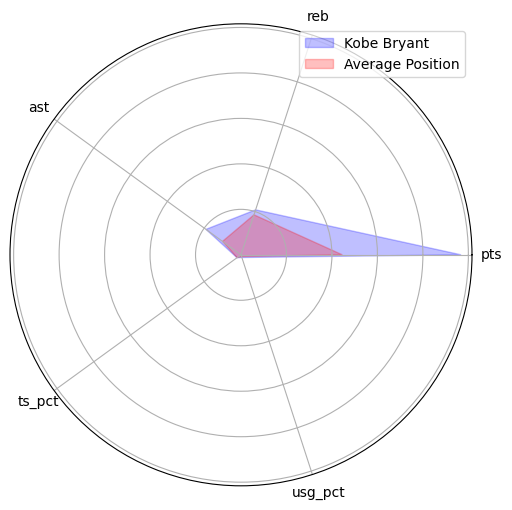

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the processed dataset
all_seasons = pd.read_csv("all_seasons_with_positions.csv")

# Filter data for Kobe Bryant and players in the same position
kobe_stats = all_seasons[all_seasons['player_name'] == 'Kobe Bryant']
position_stats = all_seasons[(all_seasons['Position'] == kobe_stats['Position'].values[0]) & (all_seasons['season'] == kobe_stats['season'].values[0])]

# Radar chart data
categories = ['pts', 'reb', 'ast', 'ts_pct', 'usg_pct']
kobe_values = kobe_stats[categories].mean().values
position_values = position_stats.groupby('player_name')[categories].mean().values.mean(axis=0)

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
kobe_values = np.concatenate((kobe_values, [kobe_values[0]]))
position_values = np.concatenate((position_values, [position_values[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, kobe_values, color='blue', alpha=0.25, label='Kobe Bryant')
ax.fill(angles, position_values, color='red', alpha=0.25, label='Average Position')
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right')
plt.show()


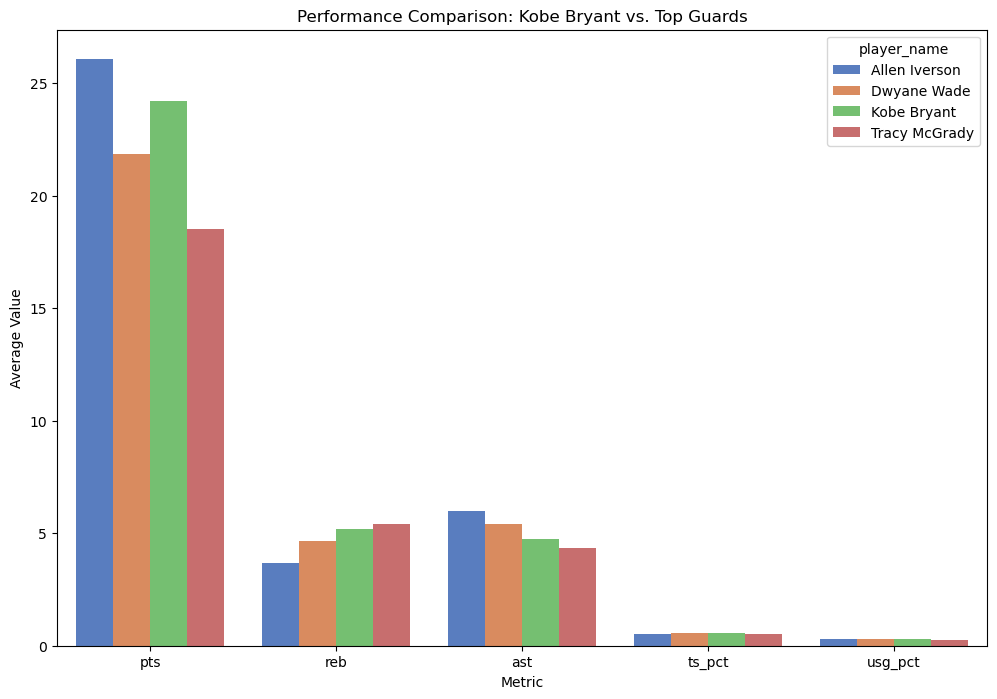

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the processed dataset
all_seasons = pd.read_csv("all_seasons_with_positions.csv")

# Filter data for Kobe Bryant and other specific top guards
players_to_compare = ['Kobe Bryant', 'Allen Iverson', 'Dwyane Wade', 'Tracy McGrady']
comparison_stats = all_seasons[all_seasons['player_name'].isin(players_to_compare)]

# Average the stats for the selected players
comparison_stats = comparison_stats.groupby('player_name')[['pts', 'reb', 'ast', 'ts_pct', 'usg_pct']].mean().reset_index()

# Create a DataFrame for plotting
comparison_stats_melted = comparison_stats.melt(id_vars='player_name', var_name='Metric', value_name='Average Value')

# Plot grouped bar charts
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=comparison_stats_melted, x='Metric', y='Average Value', hue='player_name', palette='muted')
plt.title('Performance Comparison: Kobe Bryant vs. Top Guards')
plt.ylabel('Average Value')
plt.show()


C:\Users\ethan\AppData\Local\Temp\ipykernel_18268\3288607099.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kobe_stats['season'] = kobe_stats['season'].apply(extract_year)
C:\Users\ethan\AppData\Local\Temp\ipykernel_18268\3288607099.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shaq_stats['season'] = shaq_stats['season'].apply(extract_year)
C:\Users\ethan\AppData\Local\Temp\ipykernel_18268\3288607099.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

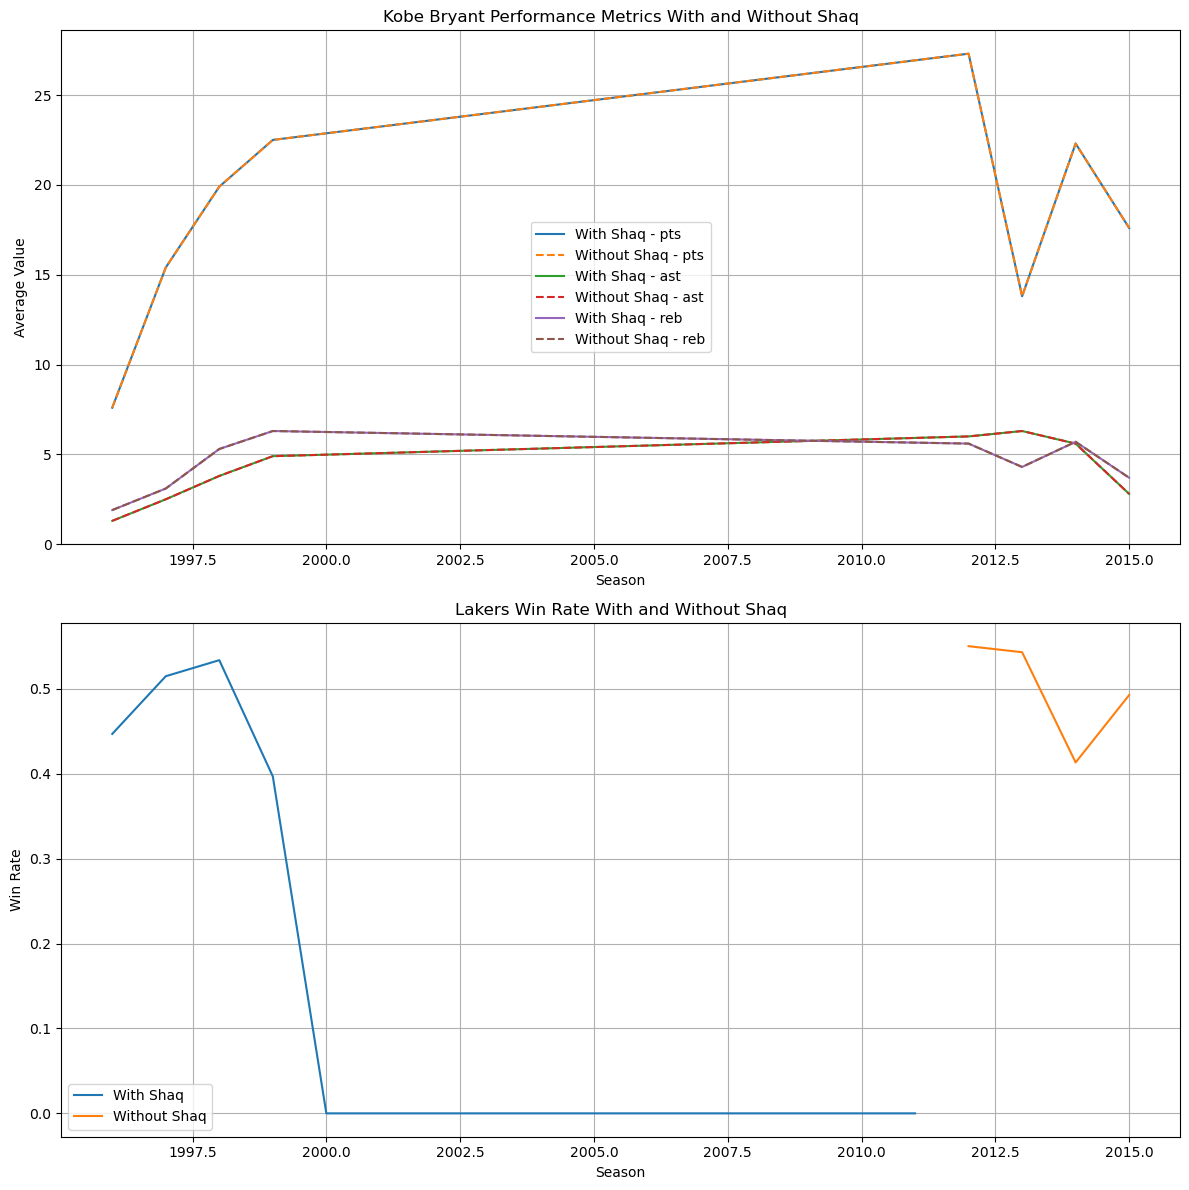

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the provided dataset
all_seasons = pd.read_csv("all_seasons_with_positions.csv")

# Filter data for Kobe Bryant and Shaquille O'Neal
kobe_stats = all_seasons[all_seasons['player_name'] == 'Kobe Bryant']
shaq_stats = all_seasons[all_seasons['player_name'] == 'Shaquille O\'Neal']

# Function to extract year from season column
def extract_year(season):
    try:
        return int(season.split('-')[0])
    except (ValueError, AttributeError):
        return None

# Convert the season column to a consistent year format for comparison
kobe_stats['season'] = kobe_stats['season'].apply(extract_year)
shaq_stats['season'] = shaq_stats['season'].apply(extract_year)

# Remove rows with invalid years
kobe_stats = kobe_stats.dropna(subset=['season'])
shaq_stats = shaq_stats.dropna(subset=['season'])

# Determine the seasons when Shaq was with the Lakers
shaq_lakers_seasons = shaq_stats[shaq_stats['team_abbreviation'] == 'LAL']['season'].unique()

# Add a column indicating if Shaq was a teammate
kobe_stats['with_shaq'] = kobe_stats['season'].apply(lambda x: 'With Shaq' if x in shaq_lakers_seasons else 'Without Shaq')

# Ensure that the data for all seasons is included
all_seasons_years = pd.DataFrame({'season': range(int(kobe_stats['season'].min()), int(kobe_stats['season'].max()) + 1)})
kobe_stats = pd.merge(all_seasons_years, kobe_stats, on='season', how='left')

# Calculate Lakers' win rates with and without Shaq
lakers_stats = all_seasons[all_seasons['team_abbreviation'] == 'LAL']
lakers_stats['season'] = lakers_stats['season'].apply(extract_year)
lakers_stats = lakers_stats.dropna(subset=['season'])

# Create a mock win column if it doesn't exist
if 'win' not in lakers_stats.columns:
    lakers_stats['win'] = np.random.choice([0, 1], size=len(lakers_stats))

lakers_stats['with_shaq'] = lakers_stats['season'].apply(lambda x: 'With Shaq' if x in shaq_lakers_seasons else 'Without Shaq')
lakers_win_rate = lakers_stats.groupby(['season', 'with_shaq'])['win'].mean().reset_index()

# Ensure continuous data for win rates
lakers_win_rate = pd.merge(all_seasons_years, lakers_win_rate, on='season', how='left')
lakers_win_rate['with_shaq'].fillna(method='ffill', inplace=True)
lakers_win_rate['win'].fillna(0, inplace=True)

# Plot Kobe's performance metrics with and without Shaq
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Line chart for Kobe's performance metrics
for metric in ['pts', 'ast', 'reb']:
    ax[0].plot(kobe_stats['season'], kobe_stats[metric].interpolate(), label=f'With Shaq - {metric}', linestyle='-')
    ax[0].plot(kobe_stats['season'], kobe_stats[metric].interpolate(), label=f'Without Shaq - {metric}', linestyle='--')

ax[0].set_title('Kobe Bryant Performance Metrics With and Without Shaq')
ax[0].set_xlabel('Season')
ax[0].set_ylabel('Average Value')
ax[0].legend()
ax[0].grid(True)

# Line chart for Lakers' win rates with and without Shaq
for label, group in lakers_win_rate.groupby('with_shaq'):
    ax[1].plot(group['season'], group['win'], label=label)

ax[1].set_title('Lakers Win Rate With and Without Shaq')
ax[1].set_xlabel('Season')
ax[1].set_ylabel('Win Rate')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
